In [400]:
# Config Data Structure
import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc

sns.set(rc={'figure.figsize': (7, 6)})
plt.rcParams['figure.figsize'] = 7,6
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

uid = "아파트4-103-106"

# TimeSlot In
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas

hh_datas = pd.DataFrame(columns=['Date Time', 'kw (15min)', 'ta (avg)', 'rhm (avg)'])
timeslot = hh_db_datas['timeslot']

wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

for wt in wt_db_datas:
    tmp = pd.DataFrame()
    tmp['date'] = [wt['date']]
    tmp['avg_ta'] = float(wt['avgTa'])
    tmp['avg_rhm'] = float(wt['avgRhm'])
    
    wt_datas = pd.concat([wt_datas, tmp])
    
avg_ta = reduce(lambda acc,cur: acc + [cur for i in range(0,96)], wt_datas['avg_ta'], [])
avg_rhm = reduce(lambda acc,cur: acc + [cur for i in range(0,96)], wt_datas['avg_rhm'], [])

hh_datas['Date Time'] = [ts['time'] for ts in timeslot]
hh_datas['kw (15min)'] = [ts['power'] for ts in timeslot]
hh_datas['ta (avg)'] = avg_ta
hh_datas['rhm (avg)'] = avg_rhm

hh_datas = hh_datas[0::4]
date_time = pd.to_datetime(hh_datas.pop('Date Time'), format="%Y-%m-%d T%H:%M Z")

hh_datas.index = date_time
hh_datas

,kw (15min),ta (avg),rhm (avg)
Date Time,,,
2018-05-01 00:00:00,0.099,20.4,72.8
2018-05-01 01:00:00,0.105,20.4,72.8
2018-05-01 02:00:00,0.094,20.4,72.8
2018-05-01 03:00:00,0.094,20.4,72.8
2018-05-01 04:00:00,0.086,20.4,72.8
...,...,...,...
2019-04-30 19:00:00,0.116,15.5,52.8
2019-04-30 20:00:00,0.045,15.5,52.8
2019-04-30 21:00:00,0.050,15.5,52.8


In [401]:
# 훈련 데이터 , 검증 데이터 나누기
# 훈련 데이터 -> 월별 90% (랜덤하게)
# 테스트 데이터 -> 월별 10% (랜덤하게)

train_datas = pd.DataFrame()
test_datas = pd.DataFrame()

for mon in range(1, 13):
    train_index = []
    val_index = []
    val_days = []
    
    mon_datas = hh_datas[
        hh_datas.index.month == mon
    ]
    max_day = len(mon_datas.index) / 24
    
    for _ in range(0, round(max_day / 10)):
        sel_day = 0
        while True:
            sel_day = ran.randrange(1, max_day + 1)
            if sel_day not in val_days:
                break
        val_days.append(sel_day)
        val_index.extend(
            mon_datas[
                mon_datas.index.day == sel_day
            ].index
        )
    print("month {} validation days {}".format(mon, val_days))
    train_datas = pd.concat([train_datas, mon_datas.drop(val_index)])
    test_datas = pd.concat([val_datas, mon_datas.loc[val_index]])
    
print("\nsetup train datas : {}".format(len(train_datas)))
print("setup test datas : {}".format(len(test_datas)))

month 1 validation days [30, 17, 3]
month 2 validation days [2, 16, 13]
month 3 validation days [29, 14, 24]
month 4 validation days [30, 14, 4]
month 5 validation days [28, 1, 25]
month 6 validation days [24, 11, 21]
month 7 validation days [10, 29, 27]
month 8 validation days [12, 10, 14]
month 9 validation days [12, 21, 13]
month 10 validation days [7, 18, 25]
month 11 validation days [29, 27, 9]
month 12 validation days [17, 25, 12]

setup train datas : 7896
setup test datas : 936


In [402]:
train_dataset = train_datas['kw (15min)'].values
test_dataset = test_datas['kw (15min)'].values

In [403]:
# 훈련데이터 - 전체 중 95%
# 검증데이터 - 전체 중 5%
TRAIN_SPLIT = round(len(train_dataset) / 95)

# Normalization
train_dataset_mean = train_dataset[:TRAIN_SPLIT].mean()
train_dataset_std = train_dataset[:TRAIN_SPLIT].std()
train_dataset = (train_dataset - train_dataset_mean) / train_dataset_std

In [404]:
train_dataset

array([-0.54222849, -0.69387383, -0.59277694, ..., -0.28948627,
       -0.04516879, -0.60120168])

In [405]:
def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    labels = []
    
    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size
        
    for i in range(start_idx, end_idx):
        indices = range(i - history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

In [406]:
univariate_past_history = 9
univariate_future_target = 0
x_train_uni, y_train_uni = univariate_data(train_dataset, 0, TRAIN_SPLIT,
                                          univariate_past_history,
                                          univariate_future_target)
x_val_uni, y_val_uni = univariate_data(train_dataset, TRAIN_SPLIT, None,
                                      univariate_past_history,
                                      univariate_future_target)

In [407]:
print("Single window of past history")
print(x_train_uni[0])
print("\nTarget temperature to predict")
print(y_train_uni[0])

Single window of past history
[[-0.54222849]
 [-0.69387383]
 [-0.59277694]
 [-0.72757279]
 [-0.54222849]
 [-0.57592746]
 [-0.71072331]
 [-0.55907797]
 [ 1.81669891]]

Target temperature to predict
0.620385726282417


In [408]:
def create_time_steps(length):
    return list(range(-length, 0))

In [409]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i],
                    label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5) * 2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


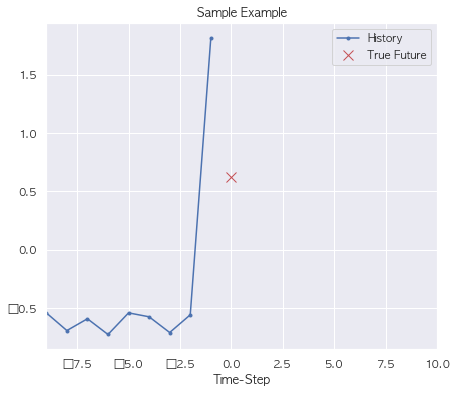

In [410]:
show_plot([x_train_uni[0], y_train_uni[0]],0,'Sample Example')

In [411]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


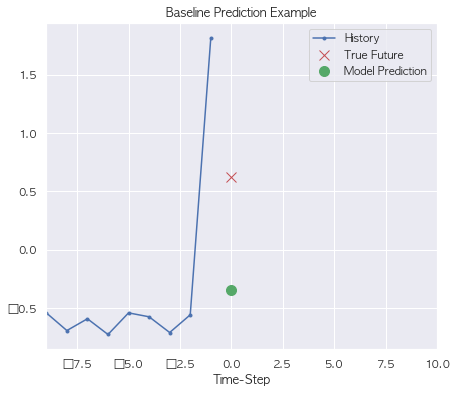

In [412]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
         'Baseline Prediction Example')

In [413]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [426]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, input_shape=x_train_uni.shape[-2:], activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001))
])
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [427]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [428]:
EVALUATION_INTERVAL = 200
EPOCHS = 40

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                     validation_data=val_univariate, validation_steps=50)

Epoch 1/40
200/200 [==============================] - 6s 28ms/step - loss: 0.5025 - val_loss: 1.2018
Epoch 2/40
200/200 [==============================] - 6s 30ms/step - loss: 0.3342 - val_loss: 1.3092
Epoch 3/40
200/200 [==============================] - 6s 30ms/step - loss: 0.2410 - val_loss: 1.3607
Epoch 4/40
200/200 [==============================] - 6s 28ms/step - loss: 0.1979 - val_loss: 1.5299
Epoch 5/40
200/200 [==============================] - 6s 30ms/step - loss: 0.1651 - val_loss: 1.5722
Epoch 6/40
200/200 [==============================] - 6s 30ms/step - loss: 0.1496 - val_loss: 1.4997
Epoch 7/40
200/200 [==============================] - 5s 26ms/step - loss: 0.1407 - val_loss: 1.3797
Epoch 8/40
200/200 [==============================] - 5s 27ms/step - loss: 0.1378 - val_loss: 1.5327
Epoch 9/40
200/200 [==============================] - 6s 28ms/step - loss: 0.1200 - val_loss: 1.4128
Epoch 10/40
200/200 [==============================] - 5s 27ms/step - loss: 0.1126 - val_lo

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


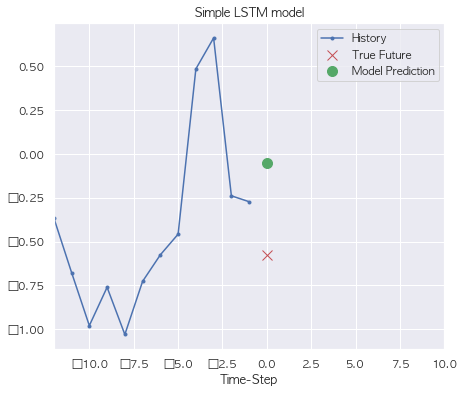

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


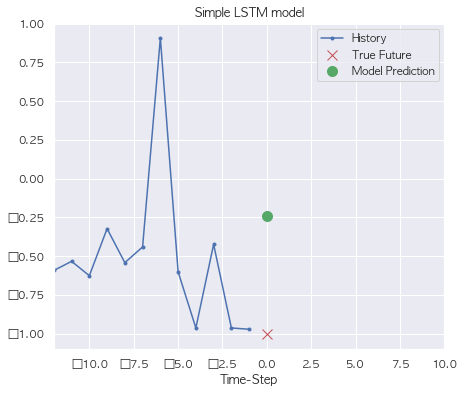

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


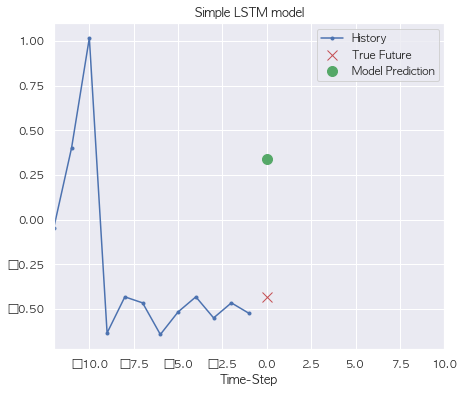

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


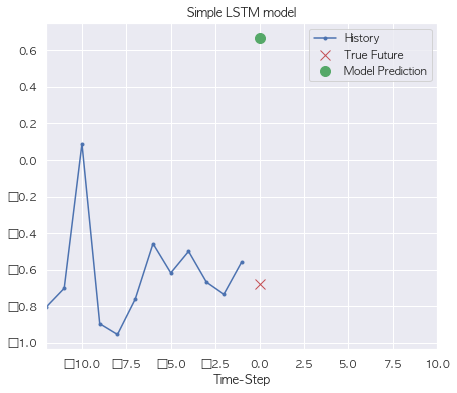

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


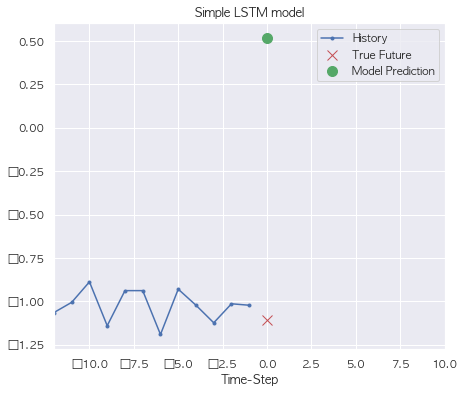

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


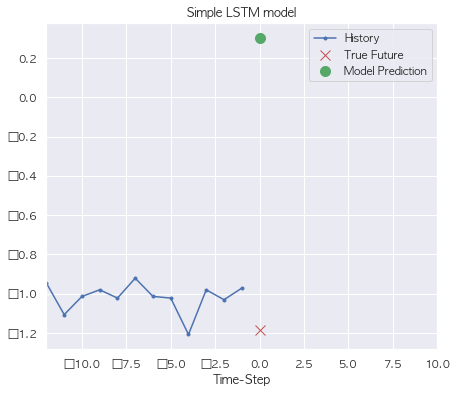

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


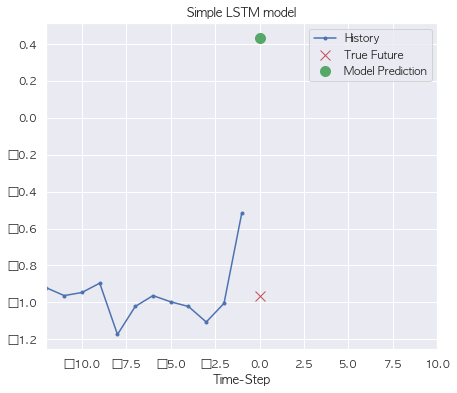

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


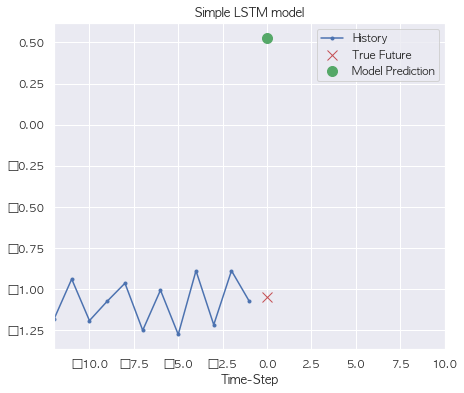

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


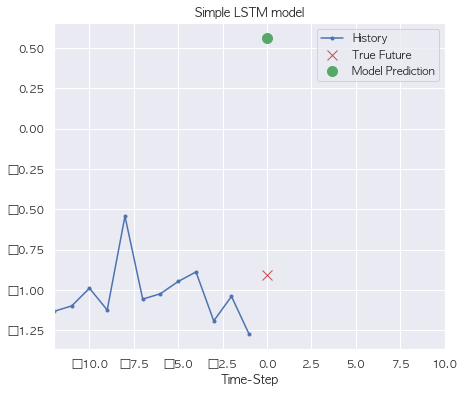

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


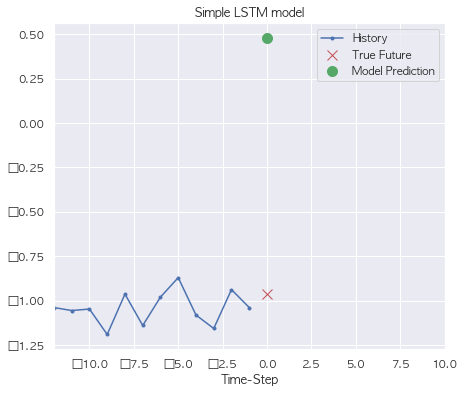

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


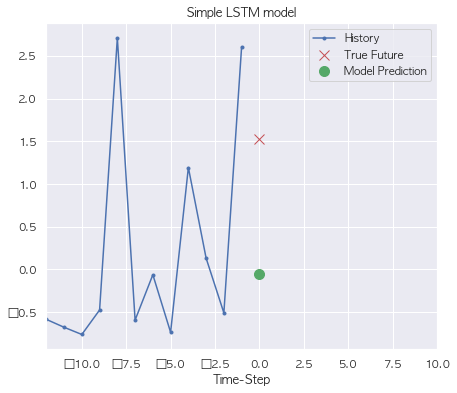

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


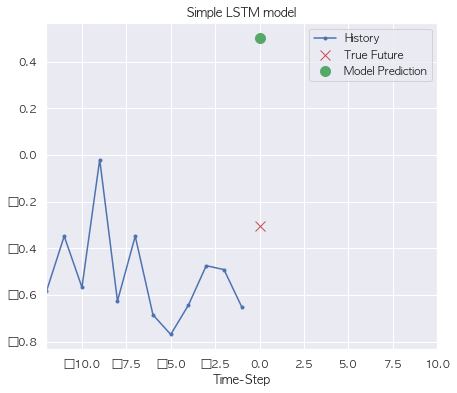

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


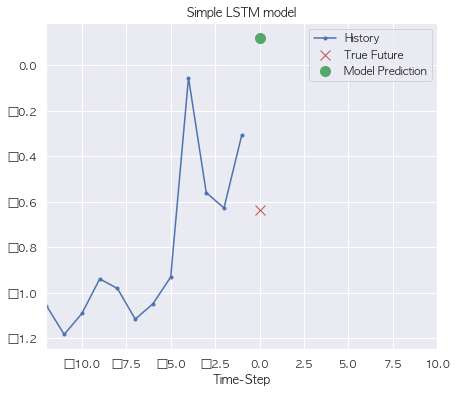

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


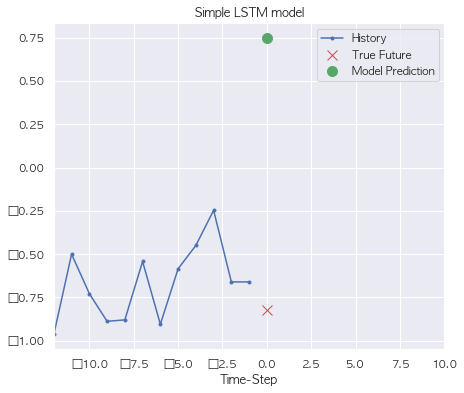

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


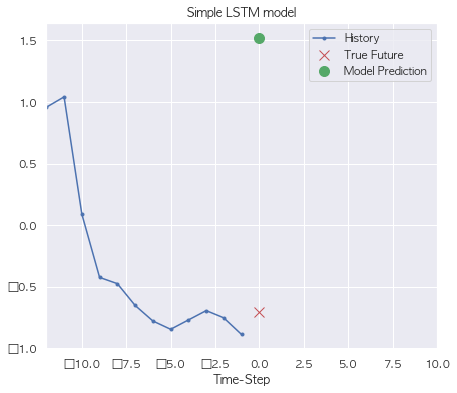

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


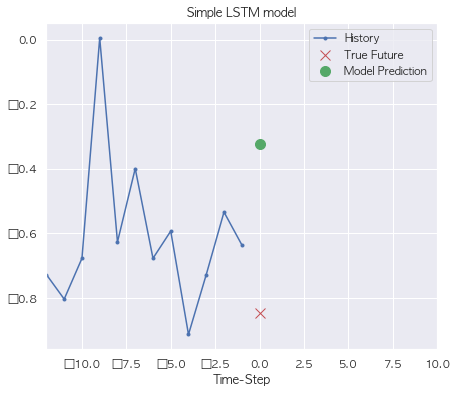

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


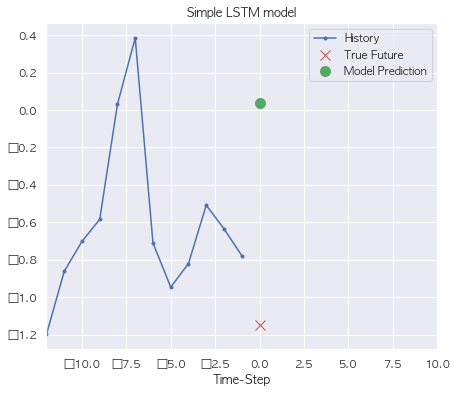

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


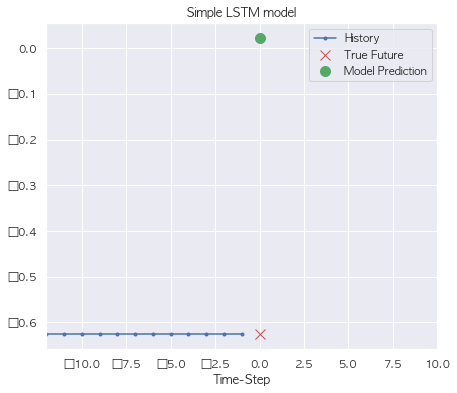

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


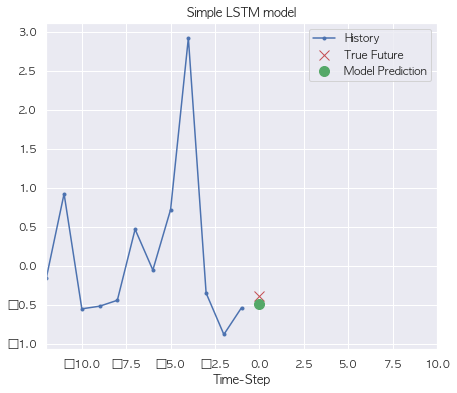

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


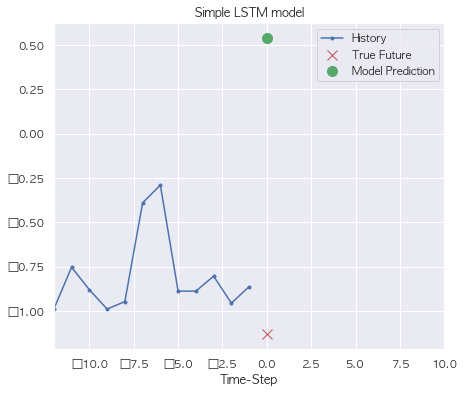

In [199]:
for x, y in val_univariate.take(20):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                     simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

In [417]:
test_dataset = (test_dataset - train_dataset_mean) / train_dataset_std

x_test_uni, y_test_uni = univariate_data(test_dataset, 0, None,
                                      univariate_past_history,
                                      univariate_future_target)

In [418]:
test_univariate = tf.data.Dataset.from_tensor_slices((x_test_uni, y_test_uni))
test_univariate = test_univariate.batch(BATCH_SIZE).repeat()

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


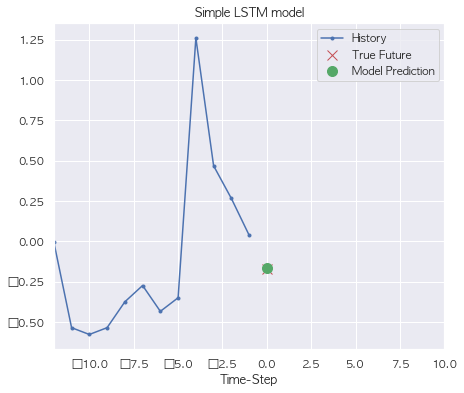

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


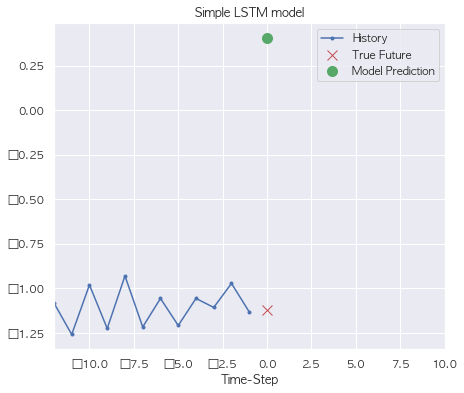

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


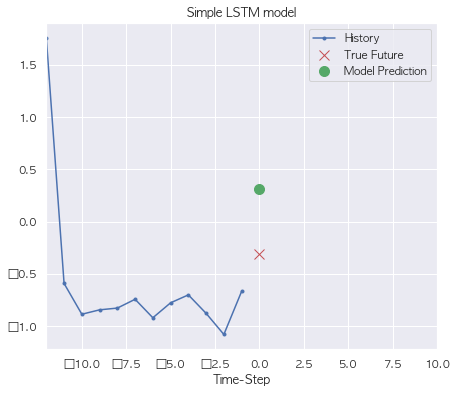

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


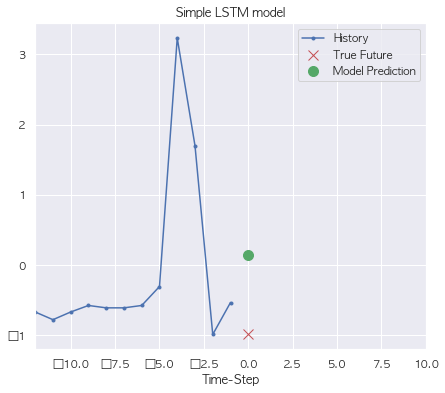

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


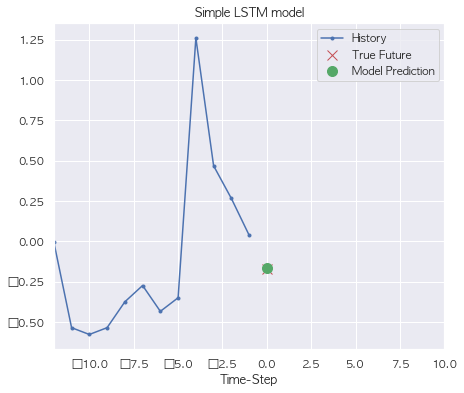

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


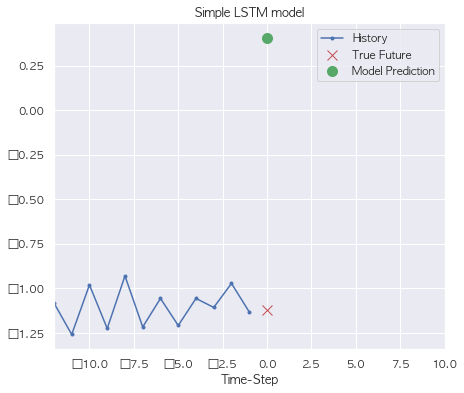

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


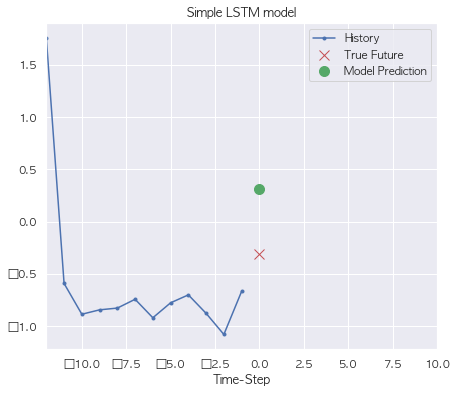

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


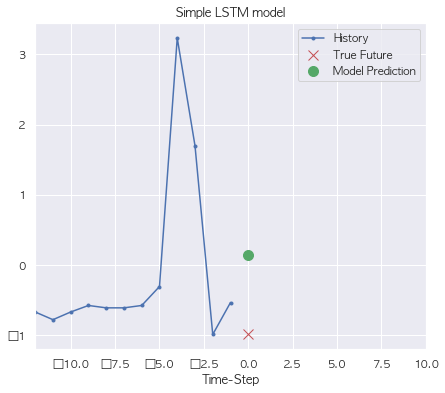

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


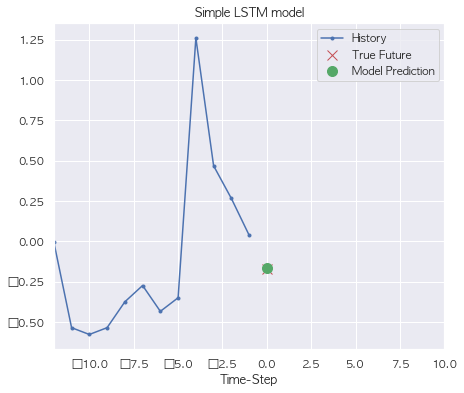

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


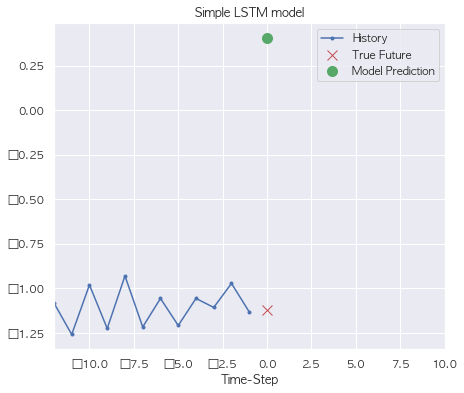

In [202]:
for x, y in test_univariate.take(10):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                     simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i],
                    label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5) * 2])
    plt.xlabel('Time-Step')
    return plt

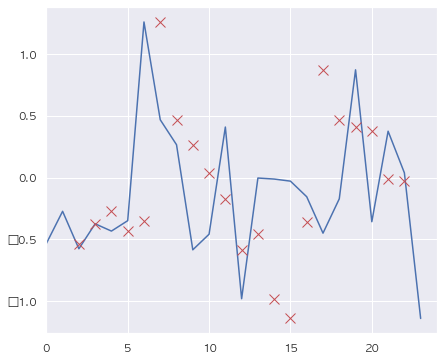

In [295]:
plt.xlim(0, 24)
plt.plot(list(set(np.array([x_test_uni[idx] for idx in range(0, 24)]).flatten())))
plt.plot(list(range(2, 23)),[y_test_uni[idx] for idx in range(0, 21)],"rx", markersize=10, label="real")


In [338]:
def get_x_24_hours(data, start_idx, end_idx):
    rtn_list = []
    for idx in range(start_idx, end_idx):
        if idx == 0:
            rtn_list = data[idx].flatten()
#             print(rtn_list)
        else:
            length = len(data[idx].flatten())
            rtn_list = np.append(rtn_list, data[idx].flatten()[length - 1])
#             print(rtn_list)
            
    return rtn_list

/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


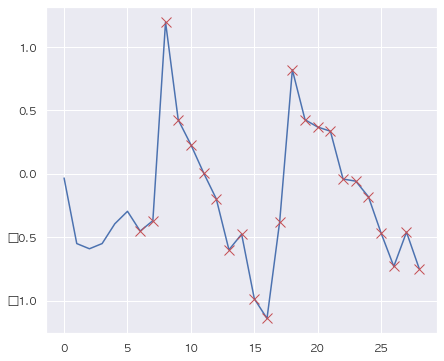

In [383]:
# plot_x = get_x_24_hours(x_test_uni, 0, 24)
plot_x = get_x_24_hours(x_test_uni, 0, 24)
plt.plot(plot_x)
# plt.plot(list(range(3, 25)),[y_test_uni[idx] for idx in range(0, 22)],"rx", markersize=10, label="real")
plt.plot(list(range(6, 29)),[y_test_uni[idx] for idx in range(0, 23)],"rx", markersize=10, label="real")

In [395]:
predict_list = []
# for x, y in test_univariate.take(21):
#     predict_list.append(simple_lstm_model.predict(x)[0][0])
for x, y in test_univariate.take(18):
    predict_list.append(simple_lstm_model.predict(x)[0][0])
    
predict_list

[-0.47565377,
 0.40632015,
 -0.6609027,
 -0.4489116,
 -0.47565377,
 0.40632015,
 -0.6609027,
 -0.4489116,
 -0.47565377,
 0.40632015,
 -0.6609027,
 -0.4489116,
 -0.47565377,
 0.40632015,
 -0.6609027,
 -0.4489116,
 -0.47565377,
 0.40632015]

24


/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/formegusto/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


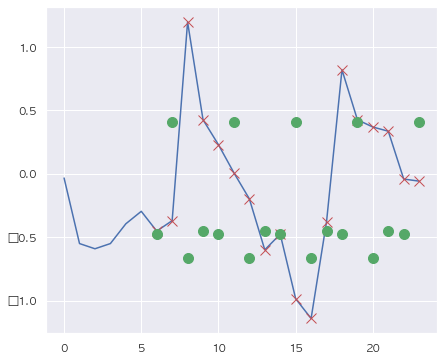

In [399]:
plot_x = get_x_24_hours(x_test_uni, 0, 19)
print(len(plot_x))
plt.plot(plot_x)
# plt.plot(list(range(3, 25)),[y_test_uni[idx] for idx in range(0, 22)],"rx", markersize=10, label="real")
plt.plot(list(range(6, 24)),[y_test_uni[idx] for idx in range(0, 18)],"rx", markersize=10, label="real")
# plt.plot(list(range(3, 24)),predict_list, "go", markersize=10, label="predict")
plt.plot(list(range(6, 24)),predict_list, "go", markersize=10, label="predict")